In [51]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers #array-like:[classifier1, classifier2, ・・・]
        self.named_classifiers = {key: value for key,value in _name_estimators(classifiers)}
         #{'linearregression':LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)}
        self.vote = vote #'classlabel(最頻)' or 'probability(所属確率)'
        self.weights = weights
    
    def fit(self, X, y):
        
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        
        return self
    
    def predict(self, X):
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:#'classlabel'
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1,arr=predictions)
        
        maj_vote = self.labelenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        
        return avg_proba
        
    def get_params(self, deep=True):
        
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out
    

In [52]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)


In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']
print('10-fold cross validation:\n')
for clf,label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]


In [54]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (+/- 0.17) [Logistic regression]
ROC AUC: 0.89 (+/- 0.16) [Decision tree]
ROC AUC: 0.88 (+/- 0.15) [KNN]
ROC AUC: 0.94 (+/- 0.13) [Majority voting]


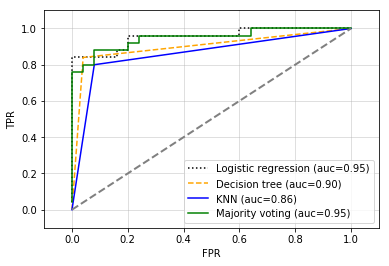

In [55]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt 

colors =['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc=%0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.show()


C:\Users\y-kobayashi\Anaconda3\envs\rein-env\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


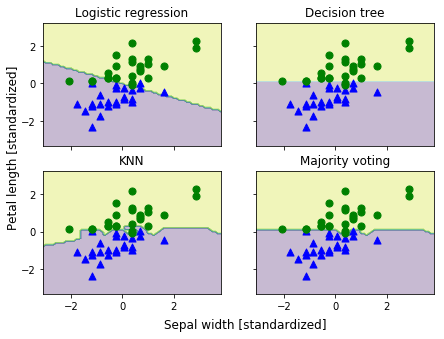

In [56]:
from itertools import product

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

x_min = X_train_std[:,0].min()-1
x_max = X_train_std[:,0].max()+1
y_min = X_train_std[:,1].min()-1
y_max = X_train_std[:,1].max()+1

xx,yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7,5))

for idx, clf, tt in zip(product([0,1], [0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='green', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)

plt.show()

In [57]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=No

In [59]:
from sklearn.model_selection import GridSearchCV

params ={'decisiontreeclassifier__max_depth':[1, 2],
         'pipeline-1__clf__C':[0.001, 0.1, 100.0]
        }

grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)


GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [72]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r" % (grid.cv_results_['mean_test_score'][r],
                                  grid.cv_results_['std_test_score'][r]/2.0,
                                  grid.cv_results_['params'][r]))

print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.933 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 +/- 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 +/- 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97
